In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.interpolate import RectBivariateSpline
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
import napari

### Get Paths to Asset Image Files

In [2]:
data_dir = 'data/images'

from pathlib import Path
loadpath = Path(data_dir)
filepaths = list(loadpath.glob('**/Asset*.jpg'))
filepaths

[WindowsPath('data/images/Asset 10.jpg'),
 WindowsPath('data/images/Asset 11.jpg'),
 WindowsPath('data/images/Asset 12.jpg')]

#### Load Image Data

In [3]:
images = []
for filepath in filepaths:
    # Load image
    image = Image.open(filepath)

    # Convert the images to grayscale
    gray_image = image.convert('L')

    # Convert the grayscale images into numpy array
    image_data = np.array(gray_image)

    # add data from individual image to list with data from all images
    images.append(image_data)

images = np.array(images)

In [ ]:
image_data

array([[203,  47,  48, ...,  47,  47, 229],
       [191,   1,   0, ...,   0,   0, 223],
       [191,   0,   0, ...,   0,   0, 223],
       ...,
       [190,   1,   0, ...,   1,   0, 223],
       [191,   0,   0, ...,   0,   0, 223],
       [227, 143, 143, ..., 143, 143, 241]],
      shape=(7655, 8960), dtype=uint8)

#### Plot Distribution of Intensities
- Purpose: Get an idea of what a potential cutoff could be

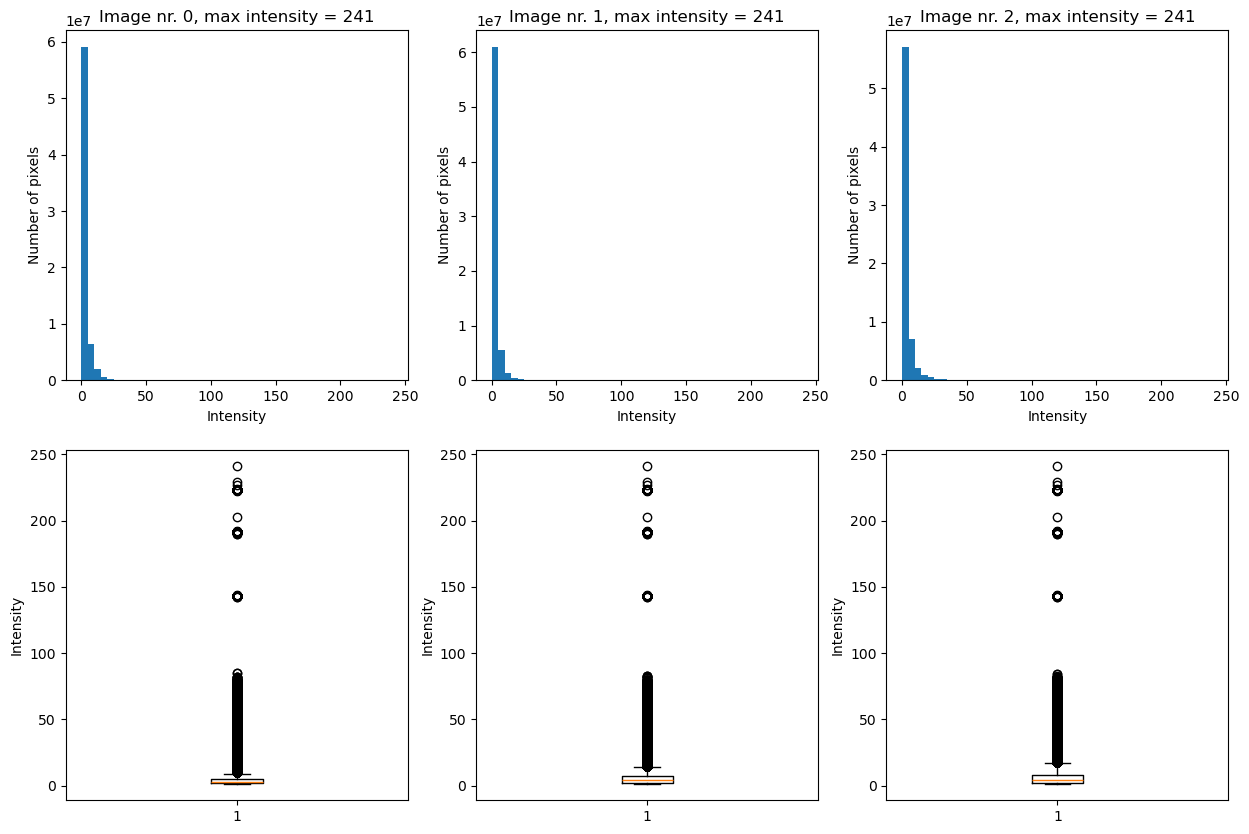

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,10))
for i in range(images.shape[0]):
    image_data = images[i]

    bins = np.arange(0, image_data.max(), 5)

    axes[0,i].hist(image_data.flatten(), bins = bins)
    axes[0,i].set_xlabel('Intensity')
    axes[0,i].set_ylabel('Number of pixels')

    axes[1,i].boxplot(image_data[image_data > 0].flatten())
    axes[1,i].set_ylabel('Intensity')
    axes[0,i].set_title(f'Image nr. {i}, max intensity = {image_data.max()}')

#### Display images before removal of artifact at border

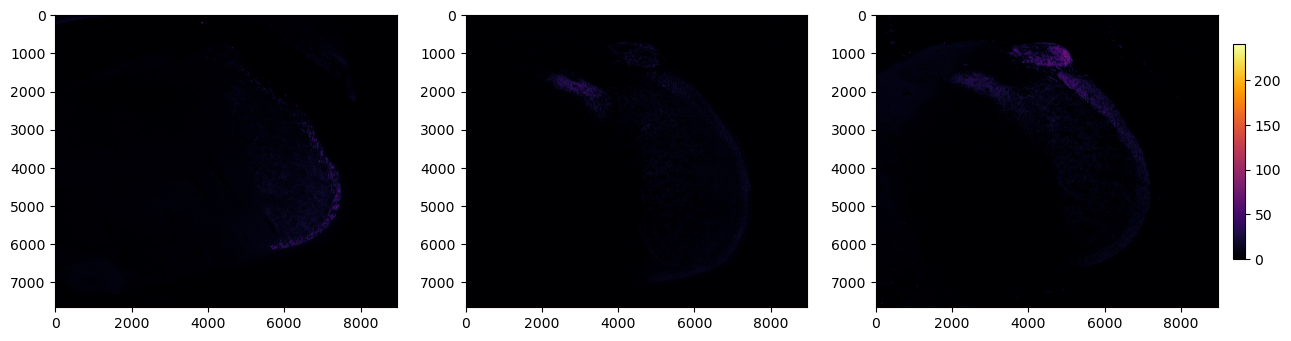

In [11]:

fig, axes = plt.subplots(ncols = 3, figsize = (15,5))
for i in range(images.shape[0]):
    ax = axes[i]
    image_data = images[i]

    im = ax.imshow(image_data, cmap = 'inferno')


cbaxes = fig.add_axes([0.91,0.30,0.008, 0.43])
cb = fig.colorbar(im, ax=ax, cax=cbaxes)

#### Check where the artifact is (that it's actually at the border)

Text(0.5, 1.0, 'Position of pixels with very high intensities in image')

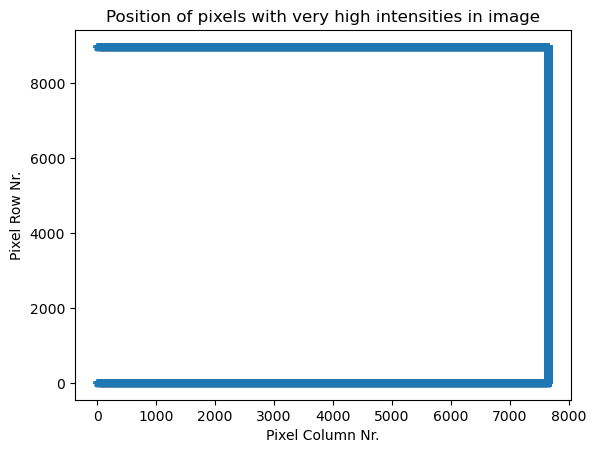

In [171]:
# get indeces of pixels with intensities higher than limit (100 chosen somewhat arbitrarily)
mask = image_data > 100
rows, cols = np.where(mask)

plt.plot(rows, cols, '*')
plt.xlabel('Pixel Column Nr.')
plt.ylabel('Pixel Row Nr.')
plt.title('Position of pixels with very high intensities in image')

#### Remove border pixels

In [117]:
image_filtered = image_data[1:-1, 1:-1]

Check that the high-intensity pixels in the image with the artifact removed are not at the border

Text(0.5, 1.0, 'Pixels with high intensities after artifact has been removed')

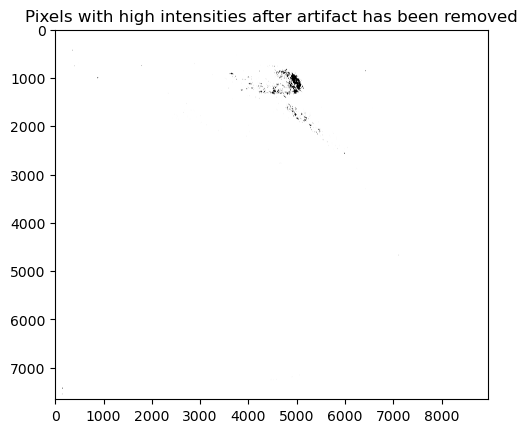

In [172]:
mask = image_filtered > 50

plt.imshow(mask, cmap = 'Greys')
plt.title('Pixels with high intensities after artifact has been removed')

#### Remove border artifacts all images

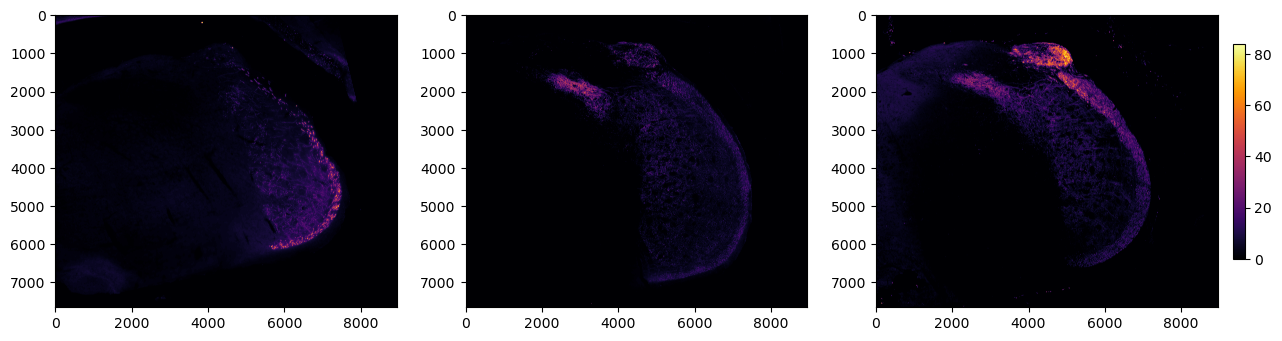

In [137]:
images_filtered= []

fig, axes = plt.subplots(ncols = 3, figsize = (15,5))
for i in range(images.shape[0]):
    ax = axes[i]
    image_data = images[i]

    image_filtered = image_data[1:-1, 1:-1]

    images_filtered.append(image_filtered)

    im = ax.imshow(image_filtered, cmap = 'inferno')

cbaxes = fig.add_axes([0.91,0.30,0.008, 0.43])
cb = fig.colorbar(im, ax=ax, cax=cbaxes)

#### Compute average without interpolation and aligning
- This assumes that the images have the same dimensions and that they are not misaligned.

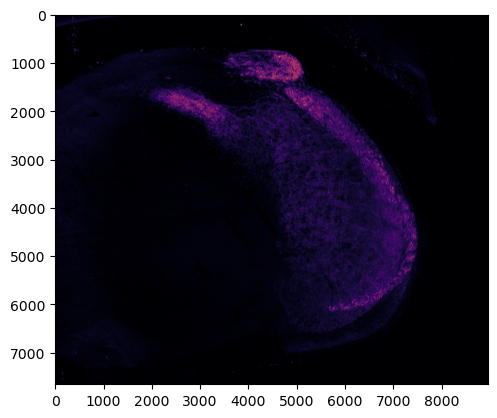

In [143]:
image_filtered_avg = np.mean(images_filtered, axis = 0)

plt.imshow(image_filtered_avg, cmap='inferno')

#### Interpolate
- This is necessary if the images don't have the same dimensions and you want to average across them

In [152]:
from scipy import interpolate

In [166]:
# Find the image that has the largest dimensions use those dimensions for the interpolation of all images
shapes = [images_filtered[i].shape for i in range(len(images_filtered))]
sizes = [images_filtered[i].size for i in range(len(images_filtered))]
x_size_basis, y_size_basis = shapes[np.argmax(sizes)]

# create x- and y-basis vectors
x_basis = np.arange(x_size_basis)
y_basis = np.arange(y_size_basis)

# go through filtered images and interpolate all of them onto the same basis so they all have the same dimensions
images_new_basis = []
for i in range(len(images_filtered)):
    image_filtered = images_filtered[i]

    # create interpolation function
    x = np.arange(image_filtered.shape[0])
    y = np.arange(image_filtered.shape[1])
    interp_func = RectBivariateSpline(x, y, image_filtered)

    # interpolate image on new basis
    image_new_basis = interp_func(x_basis, y_basis)

    # add interpolated image to list containing all interpolated images
    images_new_basis.append(image_new_basis)

images_new_basis = np.array(images_new_basis)

(7653, 8958)

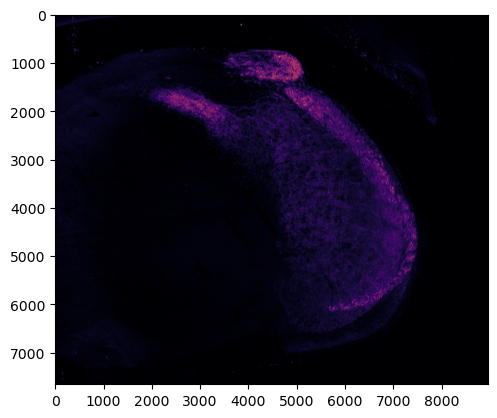

In [170]:
plt.imshow(np.mean(images_new_basis, axis = 0), cmap = 'inferno')

#### Alternative approach to removing pixels that have artifact: Set pixels that contain artifact to 0

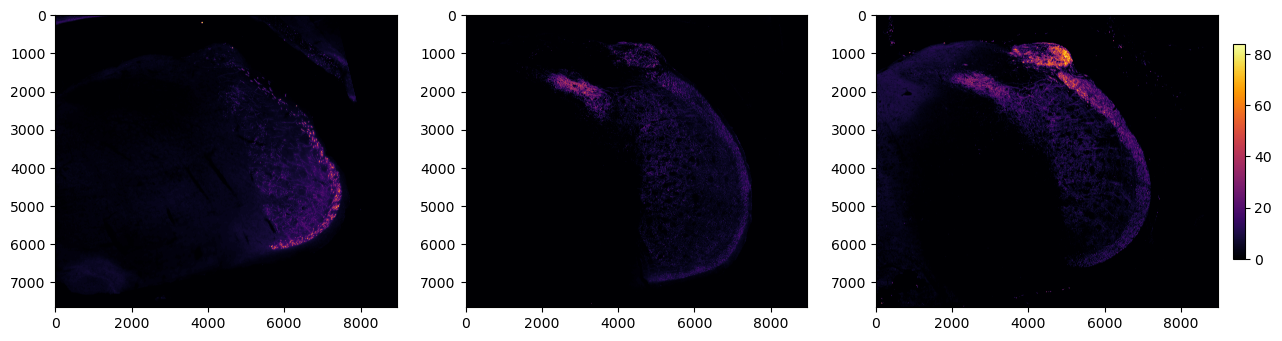

In [169]:
images_filtered= []

fig, axes = plt.subplots(ncols = 3, figsize = (15,5))
for i in range(images.shape[0]):
    ax = axes[i]
    image_data = images[i]

    # this effectively sets pixels with artifacts (extremely high intensity) to 0
    image_filtered = np.zeros_like(image_data)
    image_filtered[image_data < 100] = image_data[image_data < 100]

    images_filtered.append(image_filtered)

    im = ax.imshow(image_filtered, cmap = 'inferno')

cbaxes = fig.add_axes([0.91,0.30,0.008, 0.43])
cb = fig.colorbar(im, ax=ax, cax=cbaxes)